# Description

A company has data about users who hit the site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

The project is to:
1. Predict conversion rate
2. Come up with recommendations for the product team and the marketing team to improve conversion rate

## Index
* [Load Data](#Load-Data)
    * [Handle Age Outliers](#Handle-Age-Outliers)
    * [Conversion by Country](#Conversion-by-Country)
    * [Conversion by Age](#Conversion-by-Age)
* [Data Preprocessing](#Data-Preprocessing)
* [Classify users by Logistic Regression Model](#Classify-users-by-Logistic-Regression-Model)
* [Insights](#insights)

In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.simplefilter('ignore')

### Load Data

In [48]:
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [49]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


#### Handle Age Outliers
Max value of age is 123. Typically, age should be below 100, so firstly we need to handle the outliers.

In [50]:
df.loc[df.age>=100,:]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


if we just remove above two outliers, then what's the range of remaining ages?

In [51]:
# Check the range of age without the outliers
df.age[df.age < 100].describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

We can see, min=17, max=79, which make more sense.

In [52]:
df = df.loc[df.age < 100,:]

#### Conversion by Country

<Axes: xlabel='country'>

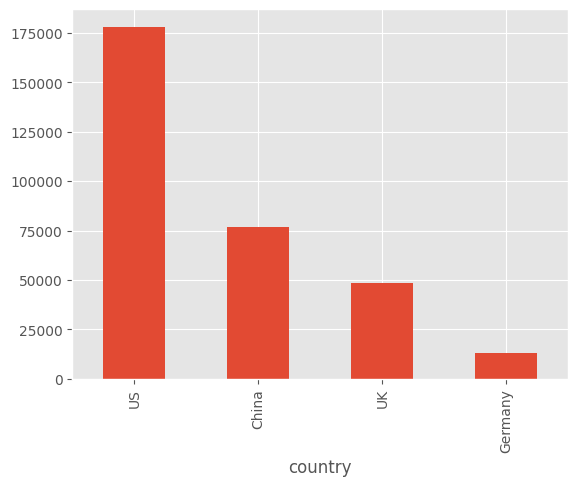

In [53]:
country_dist = df.country.value_counts()

country_dist.plot(kind = 'bar')

In [54]:
convert_by_country_dist = df.groupby('country')['converted'].mean()
convert_by_country_dist

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64

<Axes: xlabel='country'>

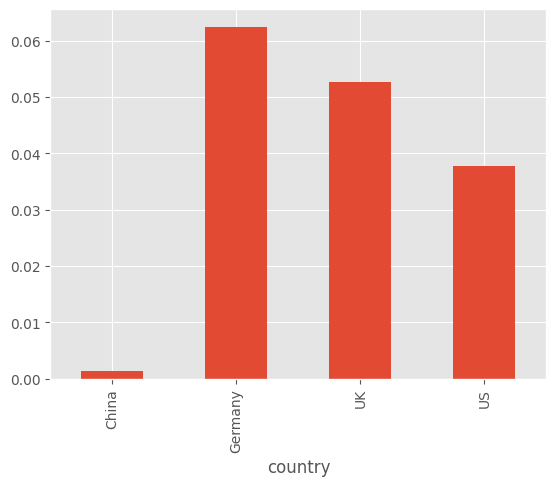

In [55]:
convert_by_country_dist.plot(kind = 'bar')

Observation:
1. There are a lot of users from China, but the conversion rate is the lowest compared to the other three countries
2. Conversion rate in Germany is very high, but the number of users from Germany is pretty low

#### Conversion by Age

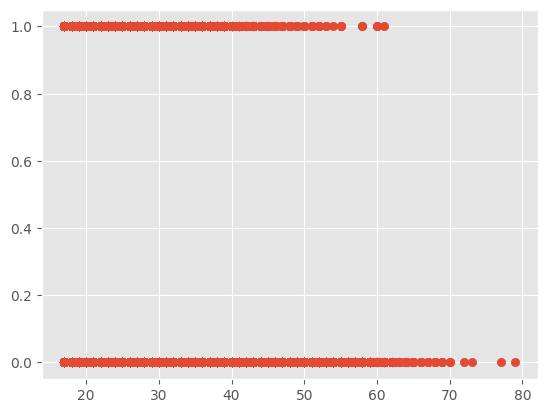

In [56]:
plt.scatter(df.age, df.converted)

The above plot indicates that there is nearly no 'conversion' from the users older than 60

### Data Preprocessing

In [57]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


As the original dataframe has categorical features 'country' and 'source', we need to use One-Hot-Encoding to transform them into numerical values

In [58]:
X = df.loc[:,('country', 'age', 'new_user', 'source', 'total_pages_visited')]
X = pd.get_dummies(X)# OHE those categorical features

In [59]:
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,False,False,True,False,True,False,False
1,23,1,5,False,False,False,True,False,False,True
2,28,1,4,False,False,False,True,False,False,True
3,39,1,5,True,False,False,False,False,False,True
4,30,1,6,False,False,False,True,False,False,True


In [60]:
y = df.converted
y.mean()

0.03225194340255157

The average shows that target value is imbalanced. In this case, using plain accuracy as a metric for evaluating a classifier can be misleading. 

In [61]:
# Split the whole dataset into 'training' dataset and 'test' dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X, y, test_size = 0.333)

In [62]:
ytrain.mean(), ytest.mean()

(0.0320287903501119, 0.032698919216669516)

Since both ytrain.mean() and ytest.mean() are similar to y.mean(), we can say the splitting process doesn't import bias

### Classify users by Logistic Regression Model

In [ ]:
## Fit the logistic regression model

lrcv = LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual = False,
                            scoring = 'roc_auc',
                            max_iter = 1000,
                            n_jobs = -1,
                            verbose = 1)
lrcv.fit(Xtrain,ytrain)

In [64]:
lrcv.C_

array([1000.])

In [65]:
lrcv.scores_

{1: array([[0.98317503, 0.98584837, 0.98631245, 0.98631075, 0.98630587,
         0.98630598, 0.98630598],
        [0.97987933, 0.98325231, 0.98408071, 0.98415201, 0.98415832,
         0.98415832, 0.98415832],
        [0.9824259 , 0.98487579, 0.98553587, 0.98563504, 0.98564437,
         0.98564437, 0.98564437],
        [0.98470075, 0.98779843, 0.98853289, 0.98862422, 0.98862422,
         0.98862422, 0.98863773],
        [0.98069251, 0.98400134, 0.98475822, 0.98479834, 0.98479394,
         0.98479394, 0.98479532]])}

In [66]:
lrcv.score(Xtrain,ytrain)

0.9859295665671745

In [67]:
lrcv.score(Xtest,ytest)

0.9862567218000732

In [68]:
1 - ytest.mean()

0.9673010807833304

In [69]:
ytest_predict = lrcv.predict(Xtest)
report = classification_report(y_true = ytest, y_pred = ytest_predict)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    101851
           1       0.86      0.69      0.77      3443

    accuracy                           0.99    105294
   macro avg       0.92      0.84      0.88    105294
weighted avg       0.99      0.99      0.99    105294



* Observation:

If we use the default cutoff 0.5, we can get a high precision (0.86), but a not very good recall (0.69), which means 31% converted users are classified as non-converted. 

Since the goal of this project is to give Sales team and Marking team some insights, we can tune the cutoff value later as it won't affect the model. If we care more about not losing valued customers, incorrectly classifing a converted user as non-converted will pay much, then we need to lower down the cut-off probability to be 1. By doing so, the model becomes more sensitive, which increases the recall at the expense of precision.

This is an imbalanced classification problem. Even if we classify every record as 'NOT converted', we can still get 96.7% accuracy (1-ytest.mean()). The LR model gives an accurancy as 99% on test dataset, which indicates that the model works.

In [70]:
# Feature importance
feat_importances = pd.DataFrame({'name':Xtrain.columns,'coef':lrcv.coef_[0]})
feat_importances = feat_importances[['name','coef']]          # reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by = 'importances', inplace=True, ascending=False)
feat_importances

,name,coef,importances
3,country_China,-2.719708,2.719708
1,new_user,-1.750766,1.750766
4,country_Germany,1.106750,1.106750
5,country_UK,0.896041,0.896041
2,total_pages_visited,0.756553,0.756553
6,country_US,0.538867,0.538867
8,source_Direct,-0.191216,0.191216
0,age,-0.074649,0.074649
7,source_Ads,0.030033,0.030033
9,source_Seo,-0.016867,0.016867


# Insights


1. Conversion among China users is bad. There are a lot of users from China, but the conversion rate is very low. Considering the huge population, there is a huge opportunity if we target Chinese market and improve Chinese users' conversion rate. For example, we should consider whether the company's website has good Chinese translation and satisfy Chinese users' culture requirement.

2. Conversion rate in Germany is very high, but the number of users from Germany is pretty low. Therefore, targeting German users is beneficial. For example, place more ads in Germany.

3. Age is a negative feature. The older the user is, the less likely they are to convert. Therefore, we should determine why young people love our web pages and strengthen those aspects. Additionally, we need to identify why older people don't find our web pages appealing and work on correcting those issues.

4. Total_pages_visited is a positive factor. The longer the user browses our web page, the more likely they are to convert and make a purchase. Therefore, if we notice users who browse extensively but don't make a purchase, we can send them an email reminder.